In [1]:
## the module that should be imported 

import numpy as np
from astropy.io import fits
import os 
from astropy.nddata.utils import Cutout2D 
import sys

print ('Import Done')

##----------------------


Import Done


Make sure that source extractor is installed in your system (some operating systems  use 'sextractor' instead 'sex').

You can use any signal detector instead of sextractor provided that you can obtain the x and y coordinates of the detected sources. In other words we just need the x and y of the source to create a cutout image.

In the cell below, set your path to the source extractor.

In [2]:
def Download_SE(image_id, Download_image=1,Extract_Sources=1):
    if Download_image==1:
        print ('Downloading the exposure (with 36 CCDs) ...')  # funpack is used to unzip the downloaded image
        os.system('curl -L https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/'+image_id+' | funpack -O '+image_id+'.fits -')
    print ('Download Done')    
    if Extract_Sources==1:
        print('Sources are being extracted....')
        fits_ = fits.open(image_id+'.fits')
        
        path='<path to source extractor>'  
        os.system(path+'sex  -c xymfhe.sex -FILTER Y -CATALOG_TYPE FITS_LDAC -CATALOG_NAME '+
              image_id+'.ldac '+'  -PARAMETERS_NAME default.param '+image_id+'.fits')   
        print ('Extract_Sources Done')

choose an ID to make 3600 random cutouts from the exposure to make it as aninput for DESOM-1

In [3]:
#image_id= '1778985p'  # RBT
image_id= '1013974p'  # GOOD



Download_SE(image_id,Download_image=0,Extract_Sources=0)  
# print ('Download Done')
##-------------------------

Download Done


The following cell uses `ldac` file which contains the coordinates of the detected sources.  

In [4]:
## loading files
fits_ = fits.open(image_id+'.fits')
ldac = fits.open(image_id+'.ldac')


n_objects=0
tot_cat=[]
n_dead_ccd=0
tot_ccd=[]
tot_images=[]
stat_images=[]


dx=32   
dy=32  # dim cutout images


sz_ldac= len(ldac)  ## check if any source found in the exposure
if sz_ldac>1: 
    

    for k2 in range(2,sz_ldac,2): 
        each_ccd=[]
        tot_ccd=[]
        ccd= k2//2  ## CCD number



        try:  ## find the the size of each CCD
            NAX1= ldac[k2-1].data[0][0][(np.where(['NAXIS1 ' in ldac[k2-1].data[0][0][k1] for k1 in range(len(ldac[k2-1].data[0][0]))])[0][0])]
            NAX1= int(NAX1.split()[2])
            NAX2= ldac[k2-1].data[0][0][(np.where(['NAXIS2 ' in ldac[k2-1].data[0][0][k1] for k1 in range(len(ldac[k2-1].data[0][0]))])[0][0])]
            NAX2= int(NAX2.split()[2])
        except:
            NAX1=2112
            NAX2=4644


        xx=ldac[k2].data['X_IMAGE']     ## cutout small images, not from image borders   
        yy=ldac[k2].data['Y_IMAGE']
        n_se= np.where((xx>dx+5) & (yy>dy+5) & (xx<NAX1-dx-5) & (yy<NAX2-dy-5) )[0]
        sz_se =len(n_se)
        if (sz_se>0):


            each_ccd=[]
            n_objects +=len(xx)
            print (' Detected sources in CCD '+str(ccd)+' =', len(xx))
            sz_ccd = len(xx) ## The number of detected sources
            xx=ldac[k2].data['X_IMAGE'][n_se] ## The X coordinate used to couout images           
            yy=ldac[k2].data['Y_IMAGE'][n_se]  ## The Y coordinate used to couout images


            
            each_ccd.append([xx,yy])
            each_ccd = np.array(each_ccd)
            each_ccd= each_ccd.T
            each_ccd = np.reshape(each_ccd,(np.shape(each_ccd)[0],np.shape(each_ccd)[1]))
            n_sam= 100  # number of coutout samples from each CCD  
            if (len(each_ccd)> n_sam): n_so = np.random.choice(range(len(each_ccd)),n_sam)
            else: n_so = np.random.choice(range(len(each_ccd)),n_sam,replace=True)
            sub_each_ccd = each_ccd[n_so]

            # Replacing possiple  NaNs with the median
            data_f= fits_[ccd].data
            shape_data= np.shape(data_f)
            data_f= np.reshape(data_f,-1)
            n_nan=np.isnan(data_f)
            med_n= np.median(data_f[~n_nan])
            data_f[np.isnan(data_f)]=med_n

            data_f= np.reshape(data_f,(shape_data))
        
        
            for kp in range(len(sub_each_ccd)):
                coor= sub_each_ccd[kp,0:]

                
                data = Cutout2D(data_f, coor, [dx,dy]).data  ## direct cut
                min_data,max_data= np.percentile(data,[1,95])  # removing outliers
                data[data>max_data]=max_data
                data[data<min_data]=min_data    
                data = (data-np.min(data))/(np.max(data)-np.min(data))  # minmax normalization
                tot_images.append(data)   

        else:   
            n_dead_ccd +=1




'''the output is:
tot_images: 3600 random couout images form an exposure with 36 CCDs, 100 from each--
n_objects: the total number of detected images that can be used as a weight in making histo-vectors--
stat_images: (reserved) you may add additional statistical information from source extractor if needed
n_dead_ccd: number of dead CCDs in an exposure based on 0 detected source
'''
out_tot=[tot_images,stat_images,n_objects,n_dead_ccd]  # 

## save the output as a Numpy file
np.save(image_id,out_tot,'dtype=object')


 Detected sources in CCD 1 = 1470
 Detected sources in CCD 2 = 1626
 Detected sources in CCD 3 = 1804
 Detected sources in CCD 4 = 1485
 Detected sources in CCD 5 = 1588
 Detected sources in CCD 6 = 1662
 Detected sources in CCD 7 = 1518
 Detected sources in CCD 8 = 1625
 Detected sources in CCD 9 = 1553
 Detected sources in CCD 10 = 1473
 Detected sources in CCD 11 = 1554
 Detected sources in CCD 12 = 1581
 Detected sources in CCD 13 = 1570
 Detected sources in CCD 14 = 1565
 Detected sources in CCD 15 = 1423
 Detected sources in CCD 16 = 1465
 Detected sources in CCD 17 = 1624
 Detected sources in CCD 18 = 1529
 Detected sources in CCD 19 = 1611
 Detected sources in CCD 20 = 1695
 Detected sources in CCD 21 = 1543
 Detected sources in CCD 22 = 1584
 Detected sources in CCD 23 = 1600
 Detected sources in CCD 24 = 1538
 Detected sources in CCD 25 = 1436
 Detected sources in CCD 26 = 1532
 Detected sources in CCD 27 = 1456
 Detected sources in CCD 28 = 1615
 Detected sources in CCD 29 =

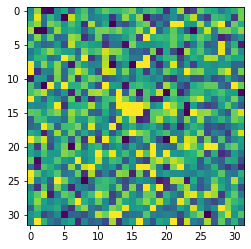

In [5]:
from matplotlib import pyplot as plt

## show 4th cutout image of 3600
img= out_tot[0][3]

plt.imshow(img)
